In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray();

In [ ]:
%run ../fetch_data.py

# Text Feature Extraction for Classification and Clustering

Outline of this section:

- Turn a corpus of text documents into **feature vectors** using a **Bag of Words** representation,
- Train a simple text classifier on the feature vectors,
- Wrap the vectorizer and the classifier with a **pipeline**,
- Cross-validation and **model selection** on the pipeline.

## Text Classification in 20 lines of Python

Let's start by implementing a canonical text classification example:

- The 20 newsgroups dataset: around 18000 text posts from 20 newsgroups forums
- Bag of Words features extraction with TF-IDF weighting
- Naive Bayes classifier or Linear Support Vector Machine for the classifier itself

In [2]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load the text data
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
twenty_train_small = load_files('../datasets/20news-bydate-train/',
    categories=categories, encoding='latin-1')
twenty_test_small = load_files('../datasets/20news-bydate-test/',
    categories=categories, encoding='latin-1')

# Turn the text documents into vectors of word frequencies
vectorizer = TfidfVectorizer(min_df=2)
X_train = vectorizer.fit_transform(twenty_train_small.data)
y_train = twenty_train_small.target

# Fit a classifier on the training set
classifier = MultinomialNB().fit(X_train, y_train)
print("Training score: {0:.1f}%".format(
    classifier.score(X_train, y_train) * 100))

# Evaluate the classifier on the testing set
X_test = vectorizer.transform(twenty_test_small.data)
y_test = twenty_test_small.target
print("Testing score: {0:.1f}%".format(
    classifier.score(X_test, y_test) * 100))

Training score: 95.1%
Testing score: 85.1%


Here is a workflow diagram summary of what happened previously:

<img src="files/images/supervised_scikit_learn.png" />

Let's now decompose what we just did to understand and customize each step.

### Loading the Dataset

Let's explore the dataset loading utility without passing a list of categories: in this case we load the full 20 newsgroups dataset in memory. The source website for the 20 newsgroups already provides a date-based train / test split that is made available using the `subset` keyword argument: 

In [3]:
ls -lh ../datasets/

total 28256
drwxr-xr-x  22 christopherallison  staff   748B 18 Mar  2003 20news-bydate-test/
drwxr-xr-x  22 christopherallison  staff   748B 18 Mar  2003 20news-bydate-train/
-rw-r--r--   1 christopherallison  staff    14M 11 Oct 12:50 20news-bydate.tar.gz


In [4]:
ls -lh ../datasets/20news-bydate-train

total 0
drwxr-xr-x  482 christopherallison  staff    16K 18 Mar  2003 alt.atheism/
drwxr-xr-x  586 christopherallison  staff    19K 18 Mar  2003 comp.graphics/
drwxr-xr-x  593 christopherallison  staff    20K 18 Mar  2003 comp.os.ms-windows.misc/
drwxr-xr-x  592 christopherallison  staff    20K 18 Mar  2003 comp.sys.ibm.pc.hardware/
drwxr-xr-x  580 christopherallison  staff    19K 18 Mar  2003 comp.sys.mac.hardware/
drwxr-xr-x  595 christopherallison  staff    20K 18 Mar  2003 comp.windows.x/
drwxr-xr-x  587 christopherallison  staff    19K 18 Mar  2003 misc.forsale/
drwxr-xr-x  596 christopherallison  staff    20K 18 Mar  2003 rec.autos/
drwxr-xr-x  600 christopherallison  staff    20K 18 Mar  2003 rec.motorcycles/
drwxr-xr-x  599 christopherallison  staff    20K 18 Mar  2003 rec.sport.baseball/
drwxr-xr-x  602 christopherallison  staff    20K 18 Mar  2003 rec.sport.hockey/
drwxr-xr-x  597 christopherallison  staff    20K 18 Mar  2003 sci.crypt/
drwxr-xr-x  593 christopherallison  sta

In [5]:
# ls -lh ../datasets/20news-bydate-train/alt.atheism/

The `load_files` function can load text files from a 2 levels folder structure assuming folder names represent categories:

In [6]:
# print(load_files.__doc__)

In [7]:
all_twenty_train = load_files('../datasets/20news-bydate-train/',
    encoding='latin-1', random_state=42)
all_twenty_test = load_files('../datasets/20news-bydate-test/',
    encoding='latin-1', random_state=42)

In [8]:
list(all_twenty_train.keys())

['data', 'filenames', 'target', 'target_names', 'DESCR']

In [9]:
all_target_names = all_twenty_train.target_names
all_target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [10]:
all_twenty_train.target

array([12,  6,  9, ...,  9,  1, 12])

In [11]:
all_twenty_train.target.shape

(11314,)

In [12]:
all_twenty_test.target.shape

(7532,)

In [13]:
len(all_twenty_train.data)

11314

In [14]:
type(all_twenty_train.data[0])

str

In [15]:
def display_sample(i, dataset):
    target_id = dataset.target[i]
    print("Class id: %d" % target_id)
    print("Class name: " + dataset.target_names[target_id])
    print("Text content:\n")
    print(dataset.data[i])

In [16]:
display_sample(0, all_twenty_train)

Class id: 12
Class name: sci.electronics
Text content:

From: wtm@uhura.neoucom.edu (Bill Mayhew)
Subject: Re: How to the disks copy protected.
Organization: Northeastern Ohio Universities College of Medicine
Lines: 23

Write a good manual to go with the software.  The hassle of
photocopying the manual is offset by simplicity of purchasing
the package for only $15.  Also, consider offering an inexpensive
but attractive perc for registered users.  For instance, a coffee
mug.  You could produce and mail the incentive for a couple of
dollars, so consider pricing the product at $17.95.

You're lucky if only 20% of the instances of your program in use
are non-licensed users.

The best approach is to estimate your loss and accomodate that into
your price structure.  Sure it hurts legitimate users, but too bad.
Retailers have to charge off loss to shoplifters onto paying
customers; the software industry is the same.

Unless your product is exceptionally unique, using an ostensibly
copy-proof 

In [17]:
display_sample(1, all_twenty_train)

Class id: 6
Class name: misc.forsale
Text content:

From: andy@SAIL.Stanford.EDU (Andy Freeman)
Subject: Re: Catalog of Hard-to-Find PC Enhancements (Repost)
Organization: Computer Science Department,  Stanford University.
Lines: 33

>andy@SAIL.Stanford.EDU (Andy Freeman) writes:
>> >In article <C5ELME.4z4@unix.portal.com> jdoll@shell.portal.com (Joe Doll) wr
>> >>   "The Catalog of Personal Computing Tools for Engineers and Scien-
>> >>   tists" lists hardware cards and application software packages for 
>> >>   PC/XT/AT/PS/2 class machines.  Focus is on engineering and scien-
>> >>   tific applications of PCs, such as data acquisition/control, 
>> >>   design automation, and data analysis and presentation.  
>> >
>> >>   If you would like a free copy, reply with your (U. S. Postal) 
>> >>   mailing address.
>> 
>> Don't bother - it never comes.  It's a cheap trick for building a
>> mailing list to sell if my junk mail flow is any indication.
>> 
>> -andy sent his address months ago
>

Let's compute the (uncompressed, in-memory) size of the training and test sets in MB assuming an 8-bit encoding (in this case, all chars can be encoded using the latin-1 charset).

In [18]:
def text_size(text, charset='iso-8859-1'):
    return len(text.encode(charset)) * 8 * 1e-6

train_size_mb = sum(text_size(text) for text in all_twenty_train.data) 
test_size_mb = sum(text_size(text) for text in all_twenty_test.data)

print("Training set size: {0} MB".format(int(train_size_mb)))
print("Testing set size: {0} MB".format(int(test_size_mb)))

Training set size: 176 MB
Testing set size: 110 MB


If we only consider a small subset of the 4 categories selected from the initial example:

In [19]:
twenty_train_small.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [20]:
train_small_size_mb = sum(text_size(text) for text in twenty_train_small.data) 
test_small_size_mb = sum(text_size(text) for text in twenty_test_small.data)

print("Training set size: {0} MB".format(int(train_small_size_mb)))
print("Testing set size: {0} MB".format(int(test_small_size_mb)))

Training set size: 31 MB
Testing set size: 22 MB


### Extracting Text Features

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer()

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
vectorizer = TfidfVectorizer(min_df=1)

%time X_train_small = vectorizer.fit_transform(twenty_train_small.data)

CPU times: user 561 ms, sys: 10.5 ms, total: 572 ms
Wall time: 571 ms


The results is not a `numpy.array` but instead a `scipy.sparse` matrix. This datastructure is quite similar to a 2D numpy array but it does not store the zeros.

In [23]:
X_train_small

<2034x34118 sparse matrix of type '<class 'numpy.float64'>'
	with 323433 stored elements in Compressed Sparse Row format>

scipy.sparse matrices also have a shape attribute to access the dimensions:

In [24]:
n_samples, n_features = X_train_small.shape

This dataset has around 2000 samples (the rows of the data matrix):

In [25]:
n_samples

2034

This is the same value as the number of strings in the original list of text documents:

In [26]:
len(twenty_train_small.data)

2034

The columns represent the individual token occurrences:

In [27]:
n_features

34118

This number is the size of the vocabulary of the model extracted during fit in a Python dictionary:

In [28]:
type(vectorizer.vocabulary_)

dict

In [29]:
len(vectorizer.vocabulary_)

34118

The keys of the `vocabulary_` attribute are also called feature names and can be accessed as a list of strings.

In [30]:
len(vectorizer.get_feature_names())

34118

Here are the first 10 elements (sorted in lexicographical order):

In [31]:
vectorizer.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '000005102000',
 '000021',
 '000062david42',
 '0000vec',
 '0001']

Let's have a look at the features from the middle:

In [32]:
vectorizer.get_feature_names()[n_features // 2:n_features // 2 + 10]

['inadequate',
 'inala',
 'inalienable',
 'inane',
 'inanimate',
 'inapplicable',
 'inappropriate',
 'inappropriately',
 'inaudible',
 'inbreeding']

Now that we have extracted a vector representation of the data, it's a good idea to project the data on the first 2D of a Principal Component Analysis to get a feel of the data. Note that the `TruncatedSVD` class can accept `scipy.sparse` matrices as input (as an alternative to numpy arrays):

In [33]:
from sklearn.decomposition import TruncatedSVD

%time X_train_small_pca = TruncatedSVD(n_components=2).fit_transform(X_train_small)

CPU times: user 95.2 ms, sys: 11.7 ms, total: 107 ms
Wall time: 103 ms


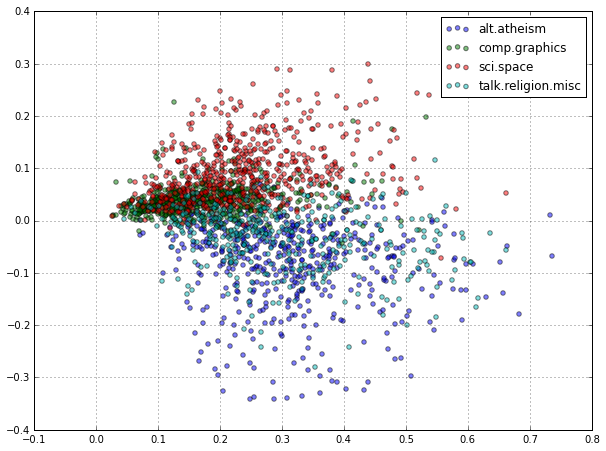

In [34]:
from itertools import cycle

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, c in zip(np.unique(y_train), cycle(colors)):
    plt.scatter(X_train_small_pca[y_train == i, 0],
               X_train_small_pca[y_train == i, 1],
               c=c, label=twenty_train_small.target_names[i], alpha=0.5)
    
plt.legend(loc='best');

We can observe that there is a large overlap of the samples from different categories. This is to be expected as the PCA linear projection projects data from a 34118 dimensional space down to 2 dimensions: data that is linearly separable in 34118D is often no longer linearly separable in 2D.
    
Still we can notice an interesting pattern: the newsgroups on religion and atheism occupy the much the same region and computer graphics and space science / space overlap more together than they do with the religion or atheism newsgroups.

### Training a Classifier on Text Features

We have previously extracted a vector representation of the training corpus and put it into a variable name `X_train_small`. To train a supervised model, in this case a classifier, we also need 

In [35]:
y_train_small = twenty_train_small.target

In [36]:
y_train_small.shape

(2034,)

In [37]:
y_train_small

array([1, 2, 2, ..., 2, 1, 1])

We can shape that we have the same number of samples for the input data and the labels:

In [38]:
X_train_small.shape[0] == y_train_small.shape[0]

True

We can now train a classifier, for instance a Multinomial Naive Bayesian classifier:

In [39]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=0.1)
clf

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [40]:
clf.fit(X_train_small, y_train_small)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

We can now evaluate the classifier on the testing set. Let's first use the builtin score function, which is the rate of correct classification in the test set:

In [ ]:
X_test_small = vectorizer.transform(twenty_test_small.data)
y_test_small = twenty_test_small.target

In [ ]:
X_test_small.shape

In [ ]:
y_test_small.shape

In [ ]:
clf.score(X_test_small, y_test_small)

We can also compute the score on the test set and observe that the model is both overfitting and underfitting a bit at the same time:

In [ ]:
clf.score(X_train_small, y_train_small)

### Introspecting the Behavior of the Text Vectorizer

The text vectorizer has many parameters to customize it's behavior, in particular how it extracts tokens:

In [ ]:
TfidfVectorizer()

In [ ]:
print(TfidfVectorizer.__doc__)

The easiest way to introspect what the vectorizer is actually doing for a given test of parameters is call the `vectorizer.build_analyzer()` to get an instance of the text analyzer it uses to process the text:

In [ ]:
analyzer = TfidfVectorizer().build_analyzer()
analyzer("I love scikit-learn: this is a cool Python lib!")

You can notice that all the tokens are lowercase, that the single letter word "I" was dropped, and that hyphenation is used. Let's change some of that default behavior:

In [ ]:
analyzer = TfidfVectorizer(
    preprocessor=lambda text: text,  # disable lowercasing
    token_pattern=r'(?u)\b[\w-]+\b', # treat hyphen as a letter
                                      # do not exclude single letter tokens
).build_analyzer()

analyzer("I love scikit-learn: this is a cool Python lib!")

The analyzer name comes from the Lucene parlance: it wraps the sequential application of:

- text preprocessing (processing the text documents as a whole, e.g. lowercasing)
- text tokenization (splitting the document into a sequence of tokens)
- token filtering and recombination (e.g. n-grams extraction, see later)

The analyzer system of scikit-learn is much more basic than lucene's though.

**Exercise**:

- Write a pre-processor callable (e.g. a python function) to remove the headers of the text a newsgroup post.
- Vectorize the data again and measure the impact on performance of removing the header info from the dataset.
- Do you expect the performance of the model to improve or decrease? What is the score of a uniform random classifier on the same dataset?

Hint: the `TfidfVectorizer` class can accept python functions to customize the `preprocessor`, `tokenizer` or `analyzer` stages of the vectorizer.
    
- type `TfidfVectorizer()` alone in a cell to see the default value of the parameters

- type `TfidfVectorizer.__doc__` to print the constructor parameters doc or `?` suffix operator on a any Python class or method to read the docstring or even the `??` operator to read the source code.

In [ ]:
%load solutions/07A_1_strip_headers.py

In [ ]:
%load solutions/07A_2_evaluate_model.py

## Model Selection of the Naive Bayes Classifier Parameter Alone

The `MultinomialNB` class is a good baseline classifier for text as it's fast and has few parameters to tweak:

In [ ]:
MultinomialNB()

In [ ]:
print(MultinomialNB.__doc__)

By reading the doc we can see that the `alpha` parameter is a good candidate to adjust the model for the bias (underfitting) vs variance (overfitting) trade-off.

**Exercise**:
    
- use the `sklearn.grid_search.GridSearchCV` or the `model_selection.RandomizedGridSeach` utility function from the previous chapters to find a good value for the parameter `alpha`
- plots the validation scores (and optionally the training scores) for each value of alpha and identify the areas where model overfits or underfits.
    
    
Hints:
    
- you can search for values of alpha in the range [0.00001 - 1] using a logarithmic scale
- `RandomizedGridSearch` also has a `launch_for_arrays` method as an alternative to `launch_for_splits` in case the CV splits have not been precomputed in advance.
1

In [ ]:
%load solutions/07B_grid_search_alpha_nb.py

In [ ]:
%load solutions/07C_validation_curves_alpha.py

## Setting Up a Pipeline for Cross Validation and Model Selection of the Feature Extraction parameters

The feature extraction class has many options to customize its behavior:

In [ ]:
print(TfidfVectorizer.__doc__)

In order to evaluate the impact of the parameters of the feature extraction one can chain a configured feature extraction and linear classifier (as an alternative to the naive Bayes model):

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline((
    ('vec', TfidfVectorizer(min_df=1, max_df=0.8, use_idf=True)),
    ('clf', PassiveAggressiveClassifier(C=1)),
))

Such a pipeline can then be cross validated or even grid searched:

In [ ]:
from sklearn.cross_validation import cross_val_score
from scipy.stats import sem

scores = cross_val_score(pipeline, twenty_train_small.data,
                         twenty_train_small.target, cv=3, n_jobs=-1)
scores.mean(), sem(scores)

For the grid search, the parameters names are prefixed with the name of the pipeline step using "__" as a separator:

In [ ]:
from sklearn.grid_search import GridSearchCV

parameters = {
    #'vec__min_df': [1, 2],
    'vec__max_df': [0.8, 1.0],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'vec__use_idf': [True, False],
}

gs = GridSearchCV(pipeline, parameters, verbose=2, refit=False)
_ = gs.fit(twenty_train_small.data, twenty_train_small.target)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

## Introspecting Model Performance

### Displaying the Most Discriminative Features

Let's fit a model on the small dataset and collect info on the fitted components:

In [ ]:
_ = pipeline.fit(twenty_train_small.data, twenty_train_small.target)

In [ ]:
vec_name, vec = pipeline.steps[0]
clf_name, clf = pipeline.steps[1]

feature_names = vec.get_feature_names()
target_names = twenty_train_small.target_names

feature_weights = clf.coef_

feature_weights.shape

By sorting the feature weights on the linear model and asking the vectorizer what their names is, one can get a clue on what the model did actually learn on the data:

In [ ]:
def display_important_features(feature_names, target_names, weights, n_top=30):
    for i, target_name in enumerate(target_names):
        print("Class: " + target_name)
        print("")
        
        sorted_features_indices = weights[i].argsort()[::-1]
        
        most_important = sorted_features_indices[:n_top]
        print(", ".join("{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in most_important))
        print("...")
        
        least_important = sorted_features_indices[-n_top:]
        print(", ".join("{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in least_important))
        print("")
        
display_important_features(feature_names, target_names, feature_weights)

### Displaying the per-class Classification Reports

In [ ]:
from sklearn.metrics import classification_report

predicted = pipeline.predict(twenty_test_small.data)

In [ ]:
print(classification_report(twenty_test_small.target, predicted,
                            target_names=twenty_test_small.target_names))

### Printing the Confusion Matrix

The confusion matrix summarize which class where by having a look at off-diagonal entries: here we can see that articles about atheism have been wrongly classified as being about religion 57 times for instance: 

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(twenty_test_small.target, predicted)
cm

In [ ]:
twenty_test_small.target_names

In [ ]:
def plot_confusion(cm, target_names, title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Convenience function to adjust plot parameters for a clear layout.
    plt.tight_layout()

plot_confusion(cm, twenty_test_small.target_names)

## Final exercise: adding a non-descriminative "junk" class

As we have seen previously, the negative features of a specific class tend.

To mitigate this issue we can try to generate some random text documents by randomly assembling snippets from all the other classes (or ideally from random text collected on the web) and give it the target name "junk" or "unknown".

Then we can retrain a model with on a new dataset with the 4 previously used classes along with our new 5-th "junk" class. We can then examine the impact on the quality of the model and the negative features for each class.

In [ ]:
%load solutions/07D_junk_class.py